In [1]:
!pip install pytorch-lightning
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, T5ForConditionalGeneration  
# from transformers import AutoModelForCausalLM, AutoTokenizer

from transformers import AdamW
import pandas as pd
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.nn.utils.rnn import pad_sequence
# from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler

pl.seed_everything(100)
import warnings
warnings.filterwarnings("ignore")

Seed set to 100


In [2]:
import os
data_train = None
data_val = None
for dir in os.listdir(os.path.abspath("/home/tanmoy/OPA/")):
    if('.' not in dir):
        print(dir)
        for file in os.listdir(os.path.abspath("/home/tanmoy/OPA")+"/"+dir):
            print('\t'+str(file))
            if('train.csv' in file):
                if(data_train is None):
                    data_train = pd.read_csv(os.path.abspath("/home/tanmoy/OPA")+"/"+dir+"/"+file)
                else:
                    data_train = data_train._append(pd.read_csv(os.path.abspath("/home/tanmoy/OPA")+"/"+dir+"/"+file))
            elif('val.csv' in file):
                if(data_val is None):
                    data_val = pd.read_csv(os.path.abspath("/home/tanmoy/OPA")+"/"+dir+"/"+file)
                else:
                    data_val = data_val._append(pd.read_csv(os.path.abspath("/home/tanmoy/OPA")+"/"+dir+"/"+file))
# data_train = pd.read_csv(os.path.abspath("/home/tanmoy/OPA/18F/18Foutput_train.csv"))
# data_val = pd.read_csv(os.path.abspath("/home/tanmoy/OPA/18F/18Foutput_val.csv"))

kolbeface
	readme.md
	kolbefaceoutput_val.csv
	kolbefaceoutput_train.csv
	kolbeface.txt
	kolbefaceoutput.csv
	kolbefaceoutput_test.csv
KarlatIwoca
	readme.md
	KarlatIwocaoutput.csv
	KarlatIwocaoutput_train.csv
	KarlatIwocaoutput_val.csv
	KarlatIwoca.txt
	KarlatIwocaoutput_test.csv
weswhet
	readme.md
	weswhetoutput_train.csv
	weswhetoutput_test.csv
	weswhet.txt
	weswhetoutput_val.csv
	weswhetoutput.csv
y0zg
	readme.md
	y0zgoutput.csv
	y0zgoutput_test.csv
	y0zg.txt
	y0zgoutput_train.csv
	y0zgoutput_val.csv
CptOfEvilMinions
	CptOfEvilMinionsoutput_test.csv
	readme.md
	CptOfEvilMinionsoutput_val.csv
	CptOfEvilMinionsoutput.csv
	CptOfEvilMinions.txt
	CptOfEvilMinionsoutput_train.csv
stephanmiehe
	readme.md
	stephanmieheoutput_test.csv
	stephanmieheoutput_train.csv
	stephanmieheoutput_val.csv
	stephanmiehe.txt
	stephanmieheoutput.csv
kyle-humane
	kyle-humaneoutput_test.csv
	readme.md
	kyle-humaneoutput_val.csv
	kyle-humaneoutput_train.csv
	kyle-humaneoutput.csv
	kyle-humane.txt
18F
	readme.m

In [4]:
data_train = data_train.sample(frac=1)
data_val= data_val.sample(frac=1)

data_train = data_train.iloc[:700,:]
data_val = data_val.iloc[:50,:]
print("No of rows in training dataset:" ,data_train.shape[0])
data_train['completion'] = data_train['completion'].apply(lambda x: x.replace('package 18F',''))
data_val['completion'] = data_val['completion'].apply(lambda x: x.replace('package 18F',''))
print("No of rows in validation dataset:" ,data_val.shape[0])
data_train.head()
data_val.head()

No of rows in training dataset: 700
No of rows in validation dataset: 50


,Unnamed: 0,prompt,completion
1,34,Team maintainers can create new queries,package y0zg\nallow { \nobject.id == 0 # new q...
0,8,All users can read software,package DominusKelvin\nallow { \nnot is_null(s...
1,17,Default deny,package CptOfEvilMinions\ndefault allow = fals...
3,4,Admins can read/write all user sessions,"package weswhet\nallow { \nobject.type == ""ses..."
6,16,Global Observer can read any policies,"package headmin\nallow { \nobject.type == ""pol..."


In [5]:
data_train['completion'] = data_train['completion'].apply(lambda x: x[x.find('\n')+1:])
data_val['completion'] = data_val['completion'].apply(lambda x: x[x.find('\n')+1:])
data_train.head()
# data_val.head()

In [6]:
data_train.head()

,Unnamed: 0,prompt,completion
34,36,"Global admins, maintainers, observer_plus and ...","allow { \nobject.type == ""team"" \nobject.id !=..."
48,95,relates to fleetctl apply).,"allow { \nobject.type == ""host_script_result"" ..."
49,78,"Team admins, maintainers, observer_plus and ob...","allow { \nobject.type == ""query"" \nis_null(obj..."
38,2,Admins can read/write all user sessions,"allow { \nobject.type == ""session"" \nsubject.g..."
27,53,Only global admins can read/write carves,"allow { \nobject.type == ""carve"" \nsubject.glo..."


In [7]:
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')
INPUT_MAX_LEN = 128 #input length
OUTPUT_MAX_LEN = 128 # output length
TRAIN_BATCH_SIZE = 8 # batch size of training
VAL_BATCH_SIZE = 2 # batch size for validation
EPOCHS = 8 # number of epoch

In [8]:
MODEL_NAME = "Salesforce/codet5-small"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_tokens(["\n"])
tokenizer.special_tokens_map

{'bos_token': '<s>',
 'eos_token': '</s>',
 'unk_token': '<unk>',
 'sep_token': '</s>',
 'pad_token': '<pad>',
 'cls_token': '<s>',
 'mask_token': '<mask>',
 'additional_special_tokens': ['<extra_id_99>',
  '<extra_id_98>',
  '<extra_id_97>',
  '<extra_id_96>',
  '<extra_id_95>',
  '<extra_id_94>',
  '<extra_id_93>',
  '<extra_id_92>',
  '<extra_id_91>',
  '<extra_id_90>',
  '<extra_id_89>',
  '<extra_id_88>',
  '<extra_id_87>',
  '<extra_id_86>',
  '<extra_id_85>',
  '<extra_id_84>',
  '<extra_id_83>',
  '<extra_id_82>',
  '<extra_id_81>',
  '<extra_id_80>',
  '<extra_id_79>',
  '<extra_id_78>',
  '<extra_id_77>',
  '<extra_id_76>',
  '<extra_id_75>',
  '<extra_id_74>',
  '<extra_id_73>',
  '<extra_id_72>',
  '<extra_id_71>',
  '<extra_id_70>',
  '<extra_id_69>',
  '<extra_id_68>',
  '<extra_id_67>',
  '<extra_id_66>',
  '<extra_id_65>',
  '<extra_id_64>',
  '<extra_id_63>',
  '<extra_id_62>',
  '<extra_id_61>',
  '<extra_id_60>',
  '<extra_id_59>',
  '<extra_id_58>',
  '<extra_id_57>

In [9]:
class T5Dataset:
    
  def __init__(self,prompt,completion):   
    
    self.prompt = prompt
    self.completion = completion
    self.tokenizer = tokenizer
    self.input_max_len = INPUT_MAX_LEN
    self.output_max_len = OUTPUT_MAX_LEN
  
  def __len__(self):                      # This method retrives the number of item from the dataset
    return len(self.prompt)

  def __getitem__(self,item):             # This method retrieves the item at the specified index item. 

    prompt = str(self.prompt[item])
    prompt = ''.join(prompt.split())

    completion = str(self.completion[item])
    completion = ' '.join(completion.split())
    # print(completion)

    input_tokenize = self.tokenizer(      
            prompt,
            add_special_tokens=True,
            max_length=self.input_max_len,
            padding = 'max_length',
            truncation = True,
            return_attention_mask=True,
            return_tensors="pt"
        )
    output_tokenize = self.tokenizer(
            completion,
            add_special_tokens=True,
            max_length=self.output_max_len,
            padding = 'max_length',
            truncation = True,
            return_attention_mask=True,
            return_tensors="pt"
            
        )
    

    input_ids = input_tokenize["input_ids"].flatten()
    attention_mask = input_tokenize["attention_mask"].flatten()
    labels = output_tokenize['input_ids'].flatten()

    out = {
            'prompt':prompt,      
            'completion':completion,
            'input_ids': input_ids,
            'attention_mask':attention_mask,
            'target':labels
        }

    return out      

In [10]:
class T5DataLoad(pl.LightningDataModule):
    
    def __init__(self,df_train,df_val):
        super().__init__()
        self.df_train = df_train
        self.df_val = df_val
        self.tokenizer = tokenizer
        self.input_max_len = INPUT_MAX_LEN
        self.out_max_len = OUTPUT_MAX_LEN
    
    def setup(self, stage=None):
        
        self.train_data = T5Dataset(
            prompt = self.df_train.prompt.values,
            completion = self.df_train.completion.values
        )
        
        self.valid_data = T5Dataset(
            prompt = self.df_val.prompt.values,
            completion = self.df_val.completion.values
        )
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
         self.train_data,
         batch_size= TRAIN_BATCH_SIZE,
         shuffle=True, 
         num_workers=2
        )
    def val_dataloader(self):
        return torch.utils.data.DataLoader(
        self.valid_data,
        batch_size= VAL_BATCH_SIZE,
        num_workers = 2
        )

In [11]:
class T5Model(pl.LightningModule):
    
    def __init__(self,model=None):
        super().__init__()
        if(model is not None):
            self.model = model
        else:
            self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict = True)
        self.train_loss = []
        self.val_loss = []
        
    def forward(self, input_ids, attention_mask, labels=None):
        
        output = self.model(
        input_ids=input_ids, 
        attention_mask=attention_mask, 
        labels=labels
        )
        return output.loss, output.logits
    
    def training_step(self, batch, batch_idx):

        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels= batch["target"]
        loss, logits = self(input_ids , attention_mask, labels)
        self.train_loss.append(loss)
        self.log("train_loss", loss, prog_bar=True, logger=True)

        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels= batch["target"]
        loss, logits = self(input_ids, attention_mask, labels)
        self.val_loss.append(loss)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        
        return {'val_loss': loss}

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)

In [12]:
def run():
    # df_train, df_val = train_test_split(data,test_size = 0.2, random_state=100)
    df_train, df_val = data_train, data_val
    dataload = T5DataLoad(df_train,df_val)
    dataload.setup()
    device = DEVICE
    model = T5Model()
    model.to(device)

    checkpoint = ModelCheckpoint(
        dirpath="./codet5_fine_tuned",
        filename='codet5-fine-tuned-final',
        save_top_k=2,
        verbose=True,
        monitor="val_loss",
        mode="min"
    )
    trainer = pl.Trainer(
        callbacks = checkpoint,
        max_epochs= EPOCHS,
        devices=1,
        accelerator="cpu"
    )
    trainer.fit(model, dataload)
    
    return model.train_loss, model.val_loss
train_loss, val_loss = run()

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
241.969   Total estimated model params size (MB)


Sanity Checking: |                                                                                       | 0/?…

Training: |                                                                                              | 0/?…

Validation: |                                                                                            | 0/?…

Epoch 0, global step 88: 'val_loss' reached 0.08127 (best 0.08127), saving model to '/home/tanmoy/policy_GPT/privateGPT_new/privategpt_server/codet5_fine_tuned/codet5-fine-tuned-final.ckpt' as top 2
`Trainer.fit` stopped: `max_epochs=1` reached.


[tensor(4.9179, grad_fn=<NllLossBackward0>), tensor(4.1245, grad_fn=<NllLossBackward0>), tensor(3.8104, grad_fn=<NllLossBackward0>), tensor(3.1800, grad_fn=<NllLossBackward0>), tensor(3.0335, grad_fn=<NllLossBackward0>), tensor(2.9596, grad_fn=<NllLossBackward0>), tensor(2.5724, grad_fn=<NllLossBackward0>), tensor(2.5829, grad_fn=<NllLossBackward0>), tensor(2.6427, grad_fn=<NllLossBackward0>), tensor(2.2986, grad_fn=<NllLossBackward0>), tensor(1.8879, grad_fn=<NllLossBackward0>), tensor(1.8124, grad_fn=<NllLossBackward0>), tensor(1.8369, grad_fn=<NllLossBackward0>), tensor(1.6851, grad_fn=<NllLossBackward0>), tensor(1.6139, grad_fn=<NllLossBackward0>), tensor(1.4554, grad_fn=<NllLossBackward0>), tensor(1.5060, grad_fn=<NllLossBackward0>), tensor(1.3060, grad_fn=<NllLossBackward0>), tensor(1.4665, grad_fn=<NllLossBackward0>), tensor(0.9484, grad_fn=<NllLossBackward0>), tensor(1.6999, grad_fn=<NllLossBackward0>), tensor(0.8493, grad_fn=<NllLossBackward0>), tensor(0.7500, grad_fn=<NllLoss

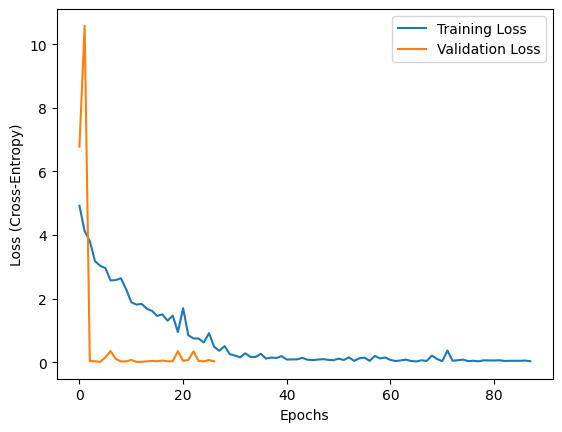

In [13]:
import matplotlib.pyplot as plt
import numpy as np

print(train_loss)
print(val_loss)

index_list_train = [i+1 for i in range(len(train_loss))]

train_loss_datapoints = []
for train_data in train_loss:
    train_data = train_data.detach().numpy()  
    train_loss_datapoints.append(train_data)
    
plt.plot(train_loss_datapoints,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (Cross-Entropy)')
plt.legend()
plt.show()

In [16]:
train_model = T5Model.load_from_checkpoint('./codet5_fine_tuned/codet5-fine-tuned-final.ckpt')
train_model.freeze()

def generate_question(question):

    inputs_encoding =  tokenizer(
        question,
        add_special_tokens=True,
        max_length= INPUT_MAX_LEN,
        padding = 'max_length',
        truncation='only_first',
        return_attention_mask=True,
        return_tensors="pt"
        )

    
    generate_ids = train_model.model.generate(
        input_ids = inputs_encoding["input_ids"],
        attention_mask = inputs_encoding["attention_mask"],
        max_length = INPUT_MAX_LEN,
        num_beams = 4,
        num_return_sequences = 1,
        no_repeat_ngram_size=2,
        early_stopping=False,
        )

    preds = [
        tokenizer.decode(gen_id,
        skip_special_tokens=True, 
        clean_up_tokenization_spaces=True)
        for gen_id in generate_ids
    ]

    return "".join(preds)


In [21]:
ques = "Admin can write global config."
print("Ques: ",ques)
print("BOT: ",generate_question(ques))

Ques:  Admin can write global config.
BOT:  allow { object.type == "app_config" subject.global_role == admin action == write }


In [33]:
text = "allow {\nobject.type == ""team""\nsubject.global_role == admin \naction == write\n} "
tokens = tokenizer.tokenize(text)
tokenized_text = tokenizer.convert_tokens_to_string(tokens)

print("tokens: ",tokens)

print("Original text:")
print(text)
print("\nTokenized text:")
print(tokenized_text)

tokens:  ['allow', 'Ġ{', '\n', 'object', '.', 'type', 'Ġ==', 'Ġteam', '\n', 'subject', '.', 'global', '_', 'role', 'Ġ==', 'Ġadmin', 'Ġ', '\n', 'action', 'Ġ==', 'Ġwrite', '\n', '}', 'Ġ']
Original text:
allow {
object.type == team
subject.global_role == admin 
action == write
} 

Tokenized text:
allow {
object.type == team
subject.global_role == admin 
action == write
} 


In [25]:
df_val.head()

NameError: name 'df_val' is not defined

In [26]:
data_train.head()

,Unnamed: 0,prompt,completion
0,8,Allow read for matching team admin/maintainer/...,"package 18F\nallow { \nobject.type == ""host"" \..."
1,26,"NOTE: Action ""read"" on a team's pack includes ...","package 18F\nallow { \nobject.type == ""pack"" \..."
2,6,Allow anyone to list (must be filtered appropr...,"package 18F\nallow { \nobject.type == ""host"" \..."
3,34,Team admin and maintainers can read and write ...,package 18F\nallow { \nnot is_null(object.team...
4,4,All users can read queries,package 18F\nallow { \nnot is_null(subject) \n...


In [17]:
data_train['prompt'].iloc[3]

'Team admin and maintainers can read and write policies for their teams'

In [33]:
' '.join(data_train['completion'].iloc[0].split(" "))

'package 18F\nallow { \nobject.type == "host" \nteam_role(subject, object.team_id) == [admin, maintainer, observer][_] \naction == read \n} \n'